dataset from: https://www.kaggle.com/datasets/davidbroberts/piano-triads-wavset

In [24]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
data_path = "/Users/elaineran/Downloads/archive2/piano_triads/"
metadata_path = "/Users/elaineran/Desktop/summer-project/triads_modified.csv"

In [ ]:
import chord_edit
import random

funcs = [chord_edit.time_stretch, chord_edit.add_noise, chord_edit.time_stretch_and_add_noise]
i = 1
while i <11:
    rand = random.randint(0, 2)
    funcs[rand](data_path, metadata_path, i)
    i+=1

In [27]:
def load_data(data_path, metadata_path):
    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"{row['Chord']}.wav")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Check if the audio length is less than the default n_fft size
        if len(audio) < 2048:
            # Pad the audio file with zeros
            audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')



        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['Chord_modified'])


    return np.array(features), np.array(labels)



In [28]:
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42)


In [30]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [35]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3168 samples, validate on 792 samples
Epoch 1/100
3168/3168 [==============================] - 5s 2ms/step - loss: 5.6763 - accuracy: 0.0319 - val_loss: 3.5490 - val_accuracy: 0.0707
Epoch 2/100
3168/3168 [==============================] - 4s 1ms/step - loss: 3.5616 - accuracy: 0.0496 - val_loss: 3.4005 - val_accuracy: 0.0821
Epoch 3/100
3168/3168 [==============================] - 5s 1ms/step - loss: 3.3373 - accuracy: 0.0922 - val_loss: 2.8614 - val_accuracy: 0.2247
Epoch 4/100
3168/3168 [==============================] - 4s 1ms/step - loss: 2.8264 - accuracy: 0.2030 - val_loss: 2.1813 - val_accuracy: 0.4192
Epoch 5/100
3168/3168 [==============================] - 4s 1ms/step - loss: 2.3655 - accuracy: 0.3242 - val_loss: 1.7457 - val_accuracy: 0.5556
Epoch 6/100
3168/3168 [==============================] - 5s 1ms/step - loss: 1.9485 - accuracy: 0.4410 - val_loss: 1.3811 - val_accuracy: 0.6427
Epoch 7/100
3168/3168 [==============================] - 5s 2ms/step - loss: 1.6039

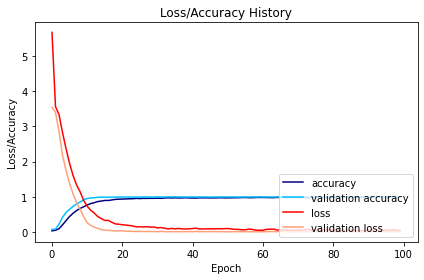

In [36]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.savefig("/Users/elaineran/Desktop/summer-project/figures/Loss-Accuracy")
plt.show()

In [37]:
test_predictions = model.predict(X_test)

In [38]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

['C_dim' 'D_min' 'G_maj' 'C_maj' 'Fs_min' 'Bb_min' 'A_maj' 'Gs_maj'
 'D_min' 'A_min' 'E_maj' 'F_maj' 'Eb_maj' 'B_min' 'A_maj' 'B_min' 'A_min'
 'B_dim' 'A_min' 'Fs_min' 'C_min' 'E_maj' 'Cs_dim' 'E_min' 'A_maj' 'A_maj'
 'Eb_maj' 'E_dim' 'D_min' 'B_min' 'B_dim' 'Bb_min' 'A_dim' 'F_maj' 'D_maj'
 'D_min' 'Fs_min' 'Gs_min' 'Fs_min' 'Gs_min' 'A_dim' 'G_dim' 'Gs_dim'
 'E_maj' 'E_min' 'F_dim' 'E_maj' 'B_maj' 'Fs_min' 'Gs_maj' 'Bb_dim'
 'B_dim' 'A_dim' 'Cs_maj' 'Bb_dim' 'Cs_min' 'Gs_min' 'A_dim' 'E_min'
 'Bb_dim' 'E_min' 'C_dim' 'Bb_maj' 'Fs_min' 'E_maj' 'D_min' 'C_maj'
 'B_min' 'Gs_min' 'F_maj' 'Eb_maj' 'Eb_min' 'E_min' 'Eb_dim' 'C_maj'
 'C_maj' 'A_dim' 'E_min' 'B_dim' 'C_min' 'Gs_maj' 'Gs_maj' 'Cs_dim'
 'E_min' 'A_min' 'C_dim' 'F_maj' 'B_min' 'B_dim' 'D_min' 'Bb_min' 'G_maj'
 'G_min' 'Gs_maj' 'D_maj' 'Eb_dim' 'Gs_maj' 'C_maj' 'Eb_maj' 'Cs_min'
 'A_maj' 'A_maj' 'Cs_dim' 'Cs_dim' 'C_min' 'A_min' 'G_min' 'C_maj'
 'Fs_maj' 'Eb_min' 'Bb_maj' 'E_min' 'E_maj' 'Bb_min' 'C_min' 'B_dim'
 'A_maj' 'B_maj'

In [39]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

['C_dim' 'D_min' 'G_maj' 'C_maj' 'Fs_min' 'Bb_min' 'A_maj' 'Gs_maj'
 'D_min' 'A_min' 'E_maj' 'F_maj' 'Eb_maj' 'B_min' 'A_maj' 'B_min' 'A_min'
 'B_dim' 'A_min' 'Fs_min' 'C_min' 'E_maj' 'Cs_dim' 'E_min' 'A_maj' 'A_maj'
 'Eb_maj' 'E_dim' 'D_min' 'B_min' 'B_dim' 'Bb_min' 'A_dim' 'F_maj' 'D_maj'
 'D_min' 'Fs_min' 'Gs_min' 'Fs_min' 'Gs_min' 'A_dim' 'G_dim' 'Gs_dim'
 'E_maj' 'E_min' 'F_dim' 'E_maj' 'B_maj' 'Fs_min' 'Gs_maj' 'Bb_dim'
 'B_dim' 'A_dim' 'Cs_maj' 'Bb_dim' 'Cs_min' 'Gs_min' 'A_dim' 'E_min'
 'Bb_dim' 'E_min' 'C_dim' 'Bb_maj' 'Fs_min' 'E_maj' 'D_min' 'C_maj'
 'B_min' 'Gs_min' 'F_maj' 'Eb_maj' 'Eb_min' 'E_min' 'Eb_dim' 'C_maj'
 'C_maj' 'A_dim' 'E_min' 'B_dim' 'C_min' 'Gs_maj' 'Gs_maj' 'Cs_dim'
 'E_min' 'A_min' 'C_dim' 'F_maj' 'B_min' 'B_dim' 'D_min' 'Bb_min' 'G_maj'
 'G_min' 'Gs_maj' 'D_maj' 'Eb_dim' 'Gs_maj' 'C_maj' 'Eb_maj' 'Cs_min'
 'A_maj' 'A_maj' 'Cs_dim' 'Cs_dim' 'C_min' 'A_min' 'G_min' 'C_maj'
 'Fs_maj' 'Eb_min' 'Bb_maj' 'E_min' 'E_maj' 'Bb_min' 'C_min' 'B_dim'
 'A_maj' 'B_maj'

In [40]:
unique_labels = np.unique(np.concatenate([y_true, predicted_class_indices]))


# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)


# Generate a classification report
print(classification_report(y_true, predicted_class_indices, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9949494949494949
              precision    recall  f1-score   support

       A_dim       1.00      1.00      1.00        11
       A_maj       1.00      1.00      1.00        23
       A_min       1.00      1.00      1.00        23
       B_dim       1.00      1.00      1.00        18
       B_maj       1.00      1.00      1.00        23
       B_min       1.00      1.00      1.00        28
      Bb_dim       1.00      1.00      1.00        14
      Bb_maj       1.00      1.00      1.00        27
      Bb_min       1.00      1.00      1.00        23
       C_dim       1.00      1.00      1.00        19
       C_maj       0.87      1.00      0.93        26
       C_min       1.00      1.00      1.00        29
      Cs_dim       1.00      1.00      1.00        14
      Cs_maj       1.00      1.00      1.00        19
      Cs_min       1.00      1.00      1.00        38
       D_dim       1.00      1.00      1.00        11
       D_maj       1.00      0.88      0.93        3

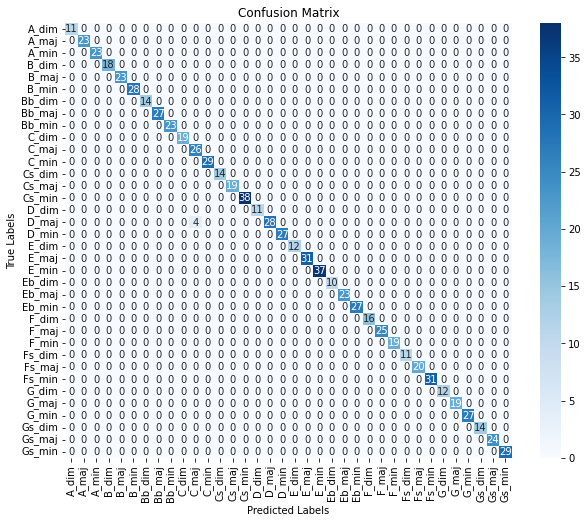

In [41]:


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/Users/elaineran/Desktop/summer-project/figures/Confusion-Matrix")
plt.show()


In [61]:
test_audio_path = "/Users/elaineran/Desktop/lol.wav"
audio, _ = librosa.load(test_audio_path, sr=22050)
# Pad the audio file if necessary
if len(audio) < 2048:
    audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
mfccs_scaled = np.mean(mfccs.T, axis=0)
mfccs_scaled = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)

# Predict the chord
predicted_probabilities = model.predict(mfccs_scaled)
predicted_label = np.argmax(predicted_probabilities, axis=1)
predicted_chord = le.inverse_transform(predicted_label)

print(f"The predicted chord is: {predicted_chord[0]}")

The predicted chord is: F_maj


In [2]:
import soundfile as sf
from pydub import AudioSegment

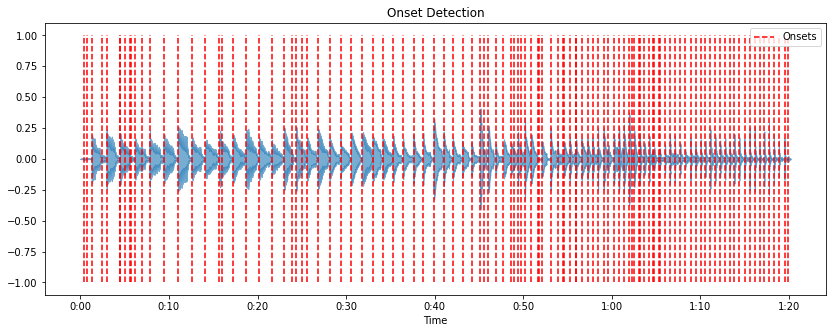

Detected onset times: [ 0.39473923  0.69659864  1.30031746  2.46131519  2.9721542   4.48145125
  4.52789116  5.0155102   5.61922902  5.75854875  6.17650794  7.0124263
  7.82512472  9.42730159 11.02947846 12.56199546 14.11773243 15.67346939
 15.9753288  17.20598639 18.71528345 20.20136054 21.61777778 23.01097506
 23.93977324 24.38095238 24.9846712  25.61160998 26.81904762 28.16580499
 29.39646259 30.58068027 31.83455782 33.04199546 34.13333333 35.31755102
 36.4553288  37.61632653 38.73088435 39.89188209 41.02965986 42.05133787
 43.14267574 44.16435374 45.11637188 45.55755102 46.04517007 46.88108844
 47.76344671 48.62258503 48.90122449 49.41206349 49.7139229  50.178322
 50.87492063 51.61795918 51.80371882 52.10557823 53.08081633 53.89351474
 54.47401361 54.59011338 55.24027211 55.91365079 55.98331066 56.61024943
 57.26040816 57.84090703 58.44462585 59.07156463 59.60562358 60.23256236
 60.81306122 61.39356009 61.92761905 62.27591837 62.53133787 63.11183673
 63.15827664 63.66911565 64.2263

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
audio_path = '/Users/elaineran/Desktop/summer-project/loser notes.wav'
sound = AudioSegment.from_file(audio_path)
wav_path = '/Users/elaineran/Desktop/summer-project/loser_notes_converted.wav'
sound.export(wav_path, format="wav")
y, sr = librosa.load(wav_path)

# Onset detection
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Plotting the waveform and onsets
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Onset Detection')
plt.legend()
plt.show()

# Print the detected onset times
print('Detected onset times:', onset_times)


In [7]:
len(onset_times)

111

In [ ]:
#not notes - 1, 2, 4, 6, 9, 10, 25

In [10]:
import librosa
import soundfile as sf
import numpy as np

# Load an audio file
audio_path = '/Users/elaineran/Desktop/summer-project/loser notes.wav'
sound = AudioSegment.from_file(audio_path)
wav_path = '/Users/elaineran/Desktop/summer-project/loser_notes_converted.wav'
sound.export(wav_path, format="wav")
y, sr = librosa.load(wav_path)

# Onset detection
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Append the end time of the audio to the onset times
onset_times = np.append(onset_times, librosa.get_duration(y=y, sr=sr))

# Split and save the audio segments
for i in range(len(onset_times) - 1):
    start_sample = int(onset_times[i] * sr)
    end_sample = int(onset_times[i + 1] * sr)
    segment = y[start_sample:end_sample]
    segment_filename = f'segment_{i + 1}.wav'
    sf.write("/Users/elaineran/Desktop/summer-project/piano_notes/" + segment_filename, segment, sr)
    print(f'Saved {segment_filename} from {onset_times[i]:.2f}s to {onset_times[i + 1]:.2f}s')


Saved segment_1.wav from 0.39s to 0.70s
Saved segment_2.wav from 0.70s to 1.30s
Saved segment_3.wav from 1.30s to 2.46s
Saved segment_4.wav from 2.46s to 2.97s
Saved segment_5.wav from 2.97s to 4.48s
Saved segment_6.wav from 4.48s to 4.53s
Saved segment_7.wav from 4.53s to 5.02s
Saved segment_8.wav from 5.02s to 5.62s
Saved segment_9.wav from 5.62s to 5.76s
Saved segment_10.wav from 5.76s to 6.18s
Saved segment_11.wav from 6.18s to 7.01s
Saved segment_12.wav from 7.01s to 7.83s
Saved segment_13.wav from 7.83s to 9.43s
Saved segment_14.wav from 9.43s to 11.03s
Saved segment_15.wav from 11.03s to 12.56s
Saved segment_16.wav from 12.56s to 14.12s
Saved segment_17.wav from 14.12s to 15.67s
Saved segment_18.wav from 15.67s to 15.98s
Saved segment_19.wav from 15.98s to 17.21s
Saved segment_20.wav from 17.21s to 18.72s
Saved segment_21.wav from 18.72s to 20.20s
Saved segment_22.wav from 20.20s to 21.62s
Saved segment_23.wav from 21.62s to 23.01s
Saved segment_24.wav from 23.01s to 23.94s
Save

In [93]:
test_audio_path = "/Users/elaineran/Desktop/summer-project/segment_3.wav"
audio, _ = librosa.load(test_audio_path, sr=22050)
# Pad the audio file if necessary
if len(audio) < 2048:
    audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
mfccs_scaled = np.mean(mfccs.T, axis=0)
mfccs_scaled = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)

# Predict the chord
predicted_probabilities = model.predict(mfccs_scaled)
predicted_label = np.argmax(predicted_probabilities, axis=1)
predicted_chord = le.inverse_transform(predicted_label)

print(f"The predicted chord is: {predicted_chord[0]}")

The predicted chord is: D_maj
